In [3]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil
import os, sys, datetime, shutil
import subprocess
from wsn_client import query
import yaml
import argparse
from configobj import ConfigObj
import logging
import time
#%matplotlib widget 

# Dictionary for variables to meteoIO input format    
dict_corres = {
    'tmp_temperature':['TA',1,273.15], # Air temperature [deg. C -> K]
    'wind_temp':['TA',1,273.15],       # Air temperature [deg. C -> K]
    'ds2_temp':['TA',1,273.15],        # Air temperature [deg. C -> K]
    'bme_tc':['TA',1,273.15],          # Air temperature [deg. C -> K]
    'bme_hum':['RH',0.01,0],           # Relative humidity [% -> 1-0]
    'sht_hum':['RH',0.01,0],           # Relative humidity [% -> 1-0]
    'mb_distance':['HS',0.001,0],          # Height of snow [mm -> m]
    'vl_distance':['HS',0.001,0],          # Height of snow [mm -> m]
    'bme_pres':['P',100,0],            # Air pressure [hPa -> Pa]
    'wind_speed':['VW',1,0],           # Wind velocity [m.s-1]
    'wind_dir':['DW',1,0],             # Wind direction [degree from North]
    'ds2_speed':['VW',1,0],            # Wind velocity [m.s-1]
    'ds2_dir':['DW',1,0],              # Wind direction [degree from North]
    'mlx_object':['TSS',1,273.15],     # Temperature of the snow surface [deg. C -> K]
    '':['TSG',1,273.15],               # Temperature of the ground surface [deg. C -> K]
    '':['VW_MAX',1,0]
}

In [9]:
# Load metadata from YML
with open('config_wsn_KNG.yml', 'r') as file:
    # Open network 
    conf = yaml.safe_load(file)
    #print(yaml.dump(yaml.safe_load(file), default_flow_style=False))

In [10]:
node=conf['node'][3]  

In [11]:

    print('======================================')
    print('---> Preparing QC node {} - {}'.format(node['id'],node['name']))

    # Open the meteoIO configuration template (ini file)  
    config_ini = ConfigObj('ini/'+node['meteoio_ini_template'])

    # Loop through several version i.e. sensor types
    for version in node['version']:
        date_start = version['date_start']
        date_end = version['date_end']
        print('---> Version {} to {}'.format(format(date_start,"%Y-%m-%d"), format(date_end,"%Y-%m-%d")))
        if not version['QC_done']:
            # Query database
            df = query.query('postgresql',
                             name=node['id'],
                             fields=version['data_sios'],
                             time__gte=date_start,
                             time__lte=date_end,
                             limit=2000000000000)
            print('---> Downloading {}'.format(version['data_sios']))

            ## Formatting
            # Replace Nones in empty lists by NaNs 
            df = df.fillna(value=np.nan)
            # Remove column with time as number
            del df['time']

            ## Snow depth calibration
            if "mb_distance" in version['data_sios']:
                print('---> Snow depth calibration')
                #df['mb_distance'] = calibration_snow(df['mb_distance'],node['snow'], conf['network']['year_hydro'])
            else:
                print('---> No snow depth data: skip calibration')

            ## Handling filenames
            fname = 'aws-{}-{}-{}'.format(node['id'],
                                      format(date_start,"%Y%m%d"),
                                      format(date_end,"%Y%m%d"))
            fname_csv = 'data/{}.csv'.format(fname)
            fname_out ='{}.nc'.format(fname)

            ## Delete existing files
            path_out = 'data_qc/{}'.format(fname_out)
            if os.path.exists(path_out):
                os.remove(path_out)
                print('---> Deleted existing file: {}'.format(path_out))

            ## Save to CSV
            print('---> Save data output in: {}'.format(fname_csv))
            df.to_csv(fname_csv)

            ## Save custom ini
            # filename ini
            fname_ini = 'ini/{}.ini'.format(fname)
            if os.path.exists(fname_ini):
                os.remove(fname_ini)
                print('---> Deleted existing file: {}'.format(fname_ini))
            print('---> Copy and fill meteoIO configurations: {}'.format(fname_ini))

            # Copy and load configuration file template for meteoIO
            shutil.copyfile('ini/'+node['meteoio_ini_template'],fname_ini)
            config_ini = ConfigObj(fname_ini)

            # [Input]
            config_ini['Input']['STATION1']='{}.csv'.format(fname) 
            config_ini['Input']['CSV_UNITS_OFFSET']='0 {}'.format(' '.join([ str(dict_corres[d][2]) for d in version['data_sios'] ]))
            config_ini['Input']['CSV_UNITS_MULTIPLIER']='1 {}'.format(' '.join([str(dict_corres[d][1]) for d in version['data_sios'] ]))
            config_ini['Input']['CSV_FIELDS']='TIMESTAMP {}'.format(' '.join([dict_corres[d][0]  for d in version['data_sios'] ]))
            config_ini['Input']['CSV_NAME']=node['id']
            config_ini['Input']['CSV_ID']=node['id']
            config_ini['Input']['POSITION']='xy({},{},{})'.format(node['location']['easting'],
                                                                  node['location']['northing'],
                                                                  node['location']['elevation'])
            # [Output]
            config_ini['Output']['METEOFILE']='{}.nc'.format(fname)
            config_ini['Output']['NC_CREATOR']=conf['ACDD']['CREATOR']
            config_ini['Output']['NC_SUMMARY']='Station {} from {}'.format(node['id'],conf['network']['description'])
            config_ini['Output']['NC_ID']=node['id']
            config_ini['Output']['ACDD_CREATOR']=conf['ACDD']['CREATOR']

            # Add ACDD values
            for ACDD,value in conf['ACDD'].items():
                if not ACDD=='WRITE':
                    config_ini['Output']['ACDD_'+ACDD]=value

            # write and copy ini - and remove double quotes
            #config_ini.write()
            #subprocess.run(['sed -i \'\' \'s/"//g\' {}'.format(fname_ini)], shell=True)
            #shutil.copyfile(fname_ini,'io.ini')
            print('---> Save meteoIO configurations and make io.ini file')

            # run MeteoIO (need to alias data_converter)
            sampling_rate = 10 # in minutes
            command = 'data_converter {} {} {}'.format(format(date_start,"%Y-%m-%dT%H:%M:%S"),format(date_end,"%Y-%m-%dT%H:%M:%S"),sampling_rate)
            print('---> command: {}'.format(command))
            #time.sleep(4)
            #subprocess.run([command], shell=True)
            print('---> Netcdf output: {}'.format(fname_out))
df

---> Preparing QC node sw-001 - KNG6
---> Version 2019-04-06 to 2021-04-29
---> Version 2021-04-29 to 2022-05-01
---> Downloading ['tmp_temperature', 'bme_hum', 'bme_pres', 'mb_distance', 'wind_dir', 'wind_speed', 'mlx_object']
---> Snow depth calibration
---> Save data output in: data/aws-sw-001-20210429-20220501.csv
---> Deleted existing file: ini/aws-sw-001-20210429-20220501.ini
---> Copy and fill meteoIO configurations: ini/aws-sw-001-20210429-20220501.ini
---> Save meteoIO configurations and make io.ini file
---> command: data_converter 2021-04-29T12:57:44 2022-05-01T00:00:00 10
---> Netcdf output: aws-sw-001-20210429-20220501.nc
---> Version 2022-05-01 to 2023-05-01


,tmp_temperature,bme_hum,bme_pres,mb_distance,wind_dir,wind_speed,mlx_object
time,,,,,,,
2021-04-29 11:00:01,-4.82,61.829998,968.639954,NaN,133,0.19,-6.470000
2021-04-29 11:10:01,-5.05,61.520000,968.709961,NaN,136,0.20,-6.630000
2021-04-29 11:20:01,-5.31,61.359997,968.789978,NaN,137,0.21,-6.770000
2021-04-29 11:30:01,-5.55,61.139999,959.789978,NaN,88,0.18,-6.890000
2021-04-29 11:40:01,-5.79,61.039997,959.570007,NaN,137,0.20,-7.190000
...,...,...,...,...,...,...,...
2022-04-09 14:40:01,-8.78,100.000000,957.329956,NaN,111,6.84,-10.969999
2022-04-09 14:50:01,-9.28,100.000000,957.299988,NaN,114,5.65,-11.290000
2022-04-09 15:00:01,-12.08,100.000000,957.500000,NaN,118,3.74,-13.190000


In [ ]:
#'xy({},{},{})'.format(node['location']['easting'],node['location']['northing'],node['location']['elevation'])
#'xy({},{},{})'.format(node['location']['easting'],node['location']['northing'],node['location']['elevation'])
config_ini['Input']['POSITION']='xy('+str(node['location']['easting'])+','+str(node['location']['northing'])+','+str(node['location']['elevation'])+')'
config_ini['Input']['POSITION']

## Calibration version 0

In [ ]:
#if len(date_snow)==len(node['snow']['depth']): date_snow.insert(0,df.index[1].date())
#if len(date_snow)==len(node['snow']['depth']): date_snow.insert(0,df.index.min().date())

# Extract dates defining a hydrological year (sept. - sept)
date_snow=node['snow']['year_hydro']

# Compute median value and assign to new column for output
df['mb_median'] = df.mb_distance.apply(lambda x: np.median(np.array(x)))
df['mb_median_corrected'] = df['mb_median']

# loop through hydrological year to calibrate snow depth
for d in range(1,len(date_snow)):
    
    # Constrain loop to calibrate only period with data
    if date_snow[d] < df.index.min().date(): break
    if date_snow[d-1] > df.index.max().date(): break
    
    # Compute distance between sensor and reference surface i.e. ice or last summer surface
    height_sensor_to_ice = node['snow']['dist_to_sensor'][d-1] + node['snow']['depth'][d-1]
    
    print('---> Process snow depth from {} to {}'.format(format(date_snow[d-1],"%Y-%m-%d"), format(date_snow[d],"%Y-%m-%d")))
    print('     Calibration reference surface to sensor: {} mm on {} '.format(height_sensor_to_ice, format(node['snow']['date'][d-1],"%Y-%m-%d")))
    #print(pd.isna(node['snow']['dist_to_sensor'][d-1]))
    
    # Calibration of snow depth - Remove negative value i.e. ice melt
    snow_depth = height_sensor_to_ice - df.mb_median[date_snow[d-1]:date_snow[d]]
    snow_depth[snow_depth<0]= 0
    
    # Assign in dataframe
    df.mb_median_corrected[date_snow[d-1]:date_snow[d]] = snow_depth

df['mb_median'].plot()
df['mb_median_corrected'].plot()

In [ ]:
########################################
# Extract dates defining a hydrological year (sept. - sept)
date_snow=node['snow']['year_hydro']

# Compute median value and assign to new column for output
df['mb_median'] = df.mb_distance.apply(lambda x: np.median(np.array(x)))

# loop through hydrological year to calibrate snow depth
for d in range(1,len(date_snow)):

    # Constrain loop to calibrate only period with data
    if date_snow[d] < df.index.min().date(): break
    if date_snow[d-1] > df.index.max().date(): break

    # Compute distance between sensor and reference surface i.e. ice or last summer surface
    height_sensor_to_ice = node['snow']['dist_to_sensor'][d-1] + node['snow']['depth'][d-1]

    print('---> Process snow depth from {} to {}'.format(format(date_snow[d-1],"%Y-%m-%d"), format(date_snow[d],"%Y-%m-%d")))
    logging.debug('     Calibration reference surface to sensor: {} mm on {} '.format(height_sensor_to_ice, format(node['snow']['date'][d-1],"%Y-%m-%d")))

    # Calibration of snow depth - Remove negative value i.e. ice melt
    snow_depth = height_sensor_to_ice - df.mb_median[date_snow[d-1]:date_snow[d]]
    snow_depth[snow_depth<0]= 0

    # Assign in dataframe
    df.mb_median[date_snow[d-1]:date_snow[d]] = snow_depth
########################################

In [ ]:
df2=query.query('postgresql',name='sw-001',fields=['mb_distance'],#'tmp_temperature', 
                                     time__gte=datetime.datetime(2019, 4, 11),
                                     time__lte=datetime.datetime(2022, 1, 1),
                                     limit=2000000000000)
print(df2.columns)

df2['mb_median'] = df2.mb_distance.apply(lambda x: np.median(np.array(x)))
plt.plot(df2['mb_median'])
plt.show()

## Calibration version 1

In [ ]:
def calibration_snow(df,node_snow,year_hydro):
    ##########################
    # Snow depth calibration #
    ##########################
    
    # Extract dates defining a hydrological year (sept. - sept)
    #date_snow=node_snow['year_hydro']

    # Compute median value and assign to new column for output
    df = df.apply(lambda x: np.median(np.array(x)))

    # loop through hydrological year to calibrate snow depth
    for d in range(1,len(year_hydro)):

        # Constrain loop to calibrate only period with data
        if year_hydro[d] < df.index.min().date(): continue
        if year_hydro[d-1] > df.index.max().date(): continue

        # Compute distance between sensor and reference surface i.e. ice or last summer surface
        height_sensor_to_ice = node_snow['dist_to_sensor'][d-1] + node_snow['depth'][d-1]

        print( '     Process snow depth from {} to {}'.format(format(year_hydro[d-1],"%Y-%m-%d"), format(year_hydro[d],"%Y-%m-%d")))
        logging.debug('     Calibration reference surface to sensor: {} mm on {} '.format(height_sensor_to_ice, format(node_snow['date'][d-1],"%Y-%m-%d")))

        # Calibration of snow depth - Remove negative value i.e. ice melt
        snow_depth = height_sensor_to_ice - df[year_hydro[d-1]:year_hydro[d]]
        snow_depth[snow_depth<0] = 0

        # Assign in dataframe
        df[year_hydro[d-1]:year_hydro[d]] = snow_depth
    return df
    ##########################
    
#df['mb_distance'] = calibration_snow(df['mb_distance'],node['snow'], conf['network']['year_hydro'])
#df['mb_distance'].plot()
#node['snow']

## Calibration version 2

In [ ]:
df2 = df['mb_distance']
node_snow = node['snow']
year_hydro = conf['network']['year_hydro']
df2 = df2.apply(lambda x: np.median(np.array(x)))
node_snow

In [ ]:
def calibration_snow(df,node_snow,year_hydro):
    ##########################
    # Snow depth calibration #
    ##########################
    
    # Time span
    date_start = df2.index.min().date()
    date_end = df2.index.max().date()
    print('Data range: {} - {}'.format(date_start,date_end))
    
    # Extract dates defining a hydrological year (sept. - sept)
    #date_snow=node_snow['year_hydro']

    # Compute median value and assign to new column for output
    df = df.apply(lambda x: np.median(np.array(x)))

    # loop through hydrological year to calibrate snow depth
    for d in range(1,len(year_hydro)):
        
        print('Hydrological year: {} - {}'.format(year_hydro[d-1],year_hydro[d]))
        #print('Last melt day: {}'.format(year_hydro[d]))

        # Constrain loop to calibrate only period with data
        if any(( year_hydro[d] < date_start, year_hydro[d-1] > date_end )):
            print("No data for hydrological year")
            continue

        # Find calibration parameters matching the hydrological year
        extract = [(date >= year_hydro[d-1] and date <= year_hydro[d]) for date in node_snow['date']]
        if not any(extract):
            print("No calibration data for hydrological year")
            continue
        date_snow = np.extract(extract,node_snow['date'])
        dist_to_sensor = np.extract(extract,node_snow['dist_to_sensor'])
        snow_depth = np.extract(extract,node_snow['depth'])

        # Compute distance between sensor and reference surface i.e. ice or last summer surface
        height_sensor_to_ice = dist_to_sensor + snow_depth
        print('     {} + {} = {}'.format(dist_to_sensor, snow_depth, height_sensor_to_ice))

        print('     Process snow depth from {} to {}'.format(format(year_hydro[d-1],"%Y-%m-%d"), format(year_hydro[d],"%Y-%m-%d")))
        print('     Calibration reference surface to sensor: {} mm on {} '.format(height_sensor_to_ice, date_snow))

        # Calibration of snow depth - Remove negative value i.e. ice melt
        snow_depth = height_sensor_to_ice - df2[year_hydro[d-1]:year_hydro[d]]
        snow_depth[snow_depth<0] = 0

        # Assign in dataframe
        df2[year_hydro[d-1]:year_hydro[d]] = snow_depth
        #df2.plot()
                                              
    return df
    ##########################
    
df['mb_distance'] = calibration_snow(df['mb_distance'],node['snow'], conf['network']['year_hydro'])
df['mb_distance'].plot()
#node['snow']

### Test

In [ ]:
    date_start = df2.index.min().date()
    date_end = df2.index.max().date()
    print('year_hydro: {} - {} ... data_span {} - {}'.format(year_hydro[d-1],year_hydro[d],date_start,date_end))

    # Constrain loop to calibrate only period with data
    if any(( year_hydro[d] < date_start, year_hydro[d-1] > date_end )):
        print("No data for hydrological year")
    
    # Find calibration parameters matching the hydrological year
    extract = [(date >= year_hydro[d-1] and date <= year_hydro[d]) for date in node_snow['date']]
    if not any(extract):
        print("No calibration data for hydrological year")

    date_snow = np.extract(extract,node_snow['date'])
    dist_to_sensor = np.extract(extract,node_snow['dist_to_sensor'])
    snow_depth = np.extract(extract,node_snow['depth'])
    
    print('{} {}'.format(dist_to_sensor, snow_depth))
    print('{}: {}'.format(date_snow, dist_to_sensor + snow_depth))

## Calibration version 3

In [150]:
df2 = df['mb_distance']
node_snow = node['snow']
year_hydro = node['date_last_melt']
date_start = df.index.min().date()
date_end = df.index.max().date()
df2 = df2.apply(lambda x: np.median(np.array(x)))
#node_snow

     Data range: 2021-04-29 - 2022-04-09
     Period 2018-09-01 - 2019-10-02: No data for hydrological year
     Period 2019-10-02 - 2020-09-01: No data for hydrological year
     Period 2020-09-01 - 2021-09-25: Apply snow calibration ... 50 + 1440 = 1490 mm on 2021-04-29
     Period 2021-09-25 - 2022-09-01: Apply snow calibration ... -3 + 1600 = 1597 mm on 2022-04-09
     Period 2022-09-01 - 2023-09-01: No data for hydrological year


<AxesSubplot:xlabel='time'>

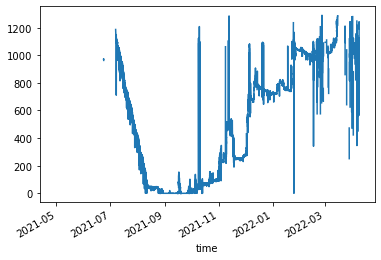

In [26]:
def calibration_snow(df,node_snow,year_hydro):
    ##########################
    # Snow depth calibration #
    ##########################
    
    # Time span
    date_start = df.index.min().date()
    date_end = df.index.max().date()
    print('     Data range: {} - {}'.format(date_start,date_end))

    # Compute median value and assign to new column for output
    df = df.apply(lambda x: np.median(np.array(x)))

    # Extract hydrological station 
    year_hydro = []
    for node_last_melt in node['date_last_melt']:
        year_hydro.append(node_last_melt['date'])

    # loop through hydrological year to calibrate snow depth
    for d in range(1,len(year_hydro)):

        # Constrain loop to calibrate only period with data
        str_hydro_year = '     Period {} - {}:'.format(year_hydro[d-1],year_hydro[d])
        if any(( year_hydro[d] < date_start, year_hydro[d-1] > date_end )):
            print('{} No data for hydrological year'.format(str_hydro_year))
            continue

        # Find calibration parameters matching the hydrological year
        date_snow = []
        dist_surf_sensor= []
        snow_depth = []
        for node_snow in node['snow']: 
            if node_snow['usage'] == 'calibration':
                date = node_snow['date']
                if date >= year_hydro[d-1] and date <= year_hydro[d]:
                    date_snow = date
                    dist_surf_sensor = node_snow['dist_surf_sensor']
                    snow_depth = node_snow['snow_depth']
                    if node_snow['dist_surf_sensor'] is None or node_snow['snow_depth'] is None:
                        print("{} No calibration data for hydrological year".format(str_hydro_year))
                        continue

        # Compute distance between sensor and reference surface i.e. ice or last summer surface
        height_sensor_to_ice = dist_surf_sensor + snow_depth
        print('{} Apply snow calibration ... {} + {} = {} mm on {}'.format(str_hydro_year,dist_surf_sensor,snow_depth,
                                                                           height_sensor_to_ice,date_snow))

        # Calibration of snow depth - Remove negative value i.e. ice melt
        snow_depth = height_sensor_to_ice - df[year_hydro[d-1]:year_hydro[d]]
        snow_depth[snow_depth<0] = 0

        # Assign in dataframe
        df[year_hydro[d-1]:year_hydro[d]] = snow_depth
        #df.plot()
                                              
    return df
    ##########################
df2['mb_distance'] = calibration_snow(df['mb_distance'],node['snow'], node['date_last_melt'])
df2['mb_distance'].plot()

In [10]:
QC_todo = None
if QC_todo: print('True')

In [142]:
date_snow = []
dist_surf_sensor= []
snow_depth = []
for node_snow in node['snow']: 
    if node_snow['usage'] == 'calibration':
        date = node_snow['date']
        date_snow.append(date)
        if date >= year_hydro[d-1] and date <= year_hydro[d]:
            dist_surf_sensor.append(node_snow['dist_surf_sensor'])
            snow_depth.append(node_snow['snow_depth'])
date_snow #dist_surf_sensor #snow_depth

[1370]

     Data range: 2021-04-29 - 2022-04-09
     Hydrological year: 2018-09-01 - 2019-09-14: No data for hydrological year
     Hydrological year: 2019-09-14 - 2020-09-01: No data for hydrological year
     Hydrological year: 2020-09-01 - 2021-09-25: Apply snow calibration ... 50 + 1440 = 1490 mm on 2021-04-29
     Hydrological year: 2021-09-25 - 2022-09-01: Apply snow calibration ... -3 + 1600 = 1597 mm on 2022-04-09
     Hydrological year: 2022-09-01 - 2023-09-01: No data for hydrological year


<AxesSubplot:xlabel='time'>

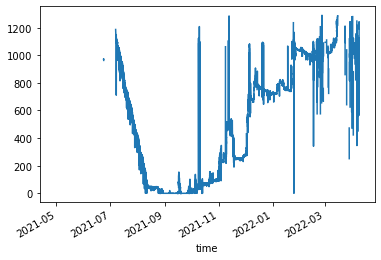

In [174]:
df2['mb_distance'] = calibration_snow(df['mb_distance'],node['snow'],node['date_last_melt'])
df2['mb_distance'].plot()

## Metadata handling for MeteoIO

In [ ]:

#df[version['data_sios']]
#node['location']
#node['network']['description']
#'xy({},{},{})'.format(node['location']['easting'],node['location']['northing'],node['location']['elevation'])

# Test dictionary
meteoio_data = [ dict_corres[d][0] for d in version['data_sios'] ]
meteoio_data_corr = [ dict_corres[d][1] for d in version['data_sios'] ]
meteoio_data_scale = [ dict_corres[d][2] for d in version['data_sios'] ]
print(meteoio_data)
print(meteoio_data_corr)
print(meteoio_data_scale)
print(' '.join([     dict_corres[d][0]  for d in version['data_sios'] ]))
print(' '.join([ str(dict_corres[d][1]) for d in version['data_sios'] ]))
print(' '.join([ str(dict_corres[d][2]) for d in version['data_sios'] ]))
'TIMESTAMP {}'.format(' '.join([dict_corres[d][0]  for d in version['data_sios'] ]))
'0 {}'.format(' '.join([str(dict_corres[d][1]) for d in version['data_sios'] ]))
'1 {}'.format(' '.join([ str(dict_corres[d][2]) for d in version['data_sios'] ]))

print(config_ini['Input']['CSV_FIELDS'])
print(config_ini['Input']['CSV_UNITS_OFFSET'])
print(config_ini['Input']['CSV_UNITS_MULTIPLIER'])
#config_ini['Input']['CSV_FIELDS']='TIMESTAMP {}'.format(' '.join(data_meteoio))
config_ini['Input']['CSV_FIELDS']='TIMESTAMP {}'.format(' '.join([dict_corres[d][0]  for d in version['data_sios'] ]))
config_ini['Input']['CSV_UNITS_MULTIPLIER']='1 {}'.format(' '.join([str(dict_corres[d][1]) for d in version['data_sios'] ]))
config_ini['Input']['CSV_UNITS_OFFSET']='0 {}'.format(' '.join([ str(dict_corres[d][2]) for d in version['data_sios'] ]))